In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Load your dataset of cities with their coordinates
def load_dataset(filename):
    data = np.loadtxt(filename, delimiter=',')
    return data
filename = "dataset/large.csv"
cities = load_dataset(filename)
num_cities = len(cities)

In [3]:
# Calculate Euclidean distance between two cities to use it to calc the total distance later on 
def distance(city1, city2):
    return np.linalg.norm(city1 - city2)

In [4]:
# function that find the nearest neighbor for a city 
def nearest_neighbor_initial_route(cities, start_city):
    num_cities = len(cities)
    current_city = start_city
    unvisited_cities = set(range(num_cities))
    route = [current_city]
    unvisited_cities.remove(current_city)

    while unvisited_cities:
        nearest_city = min(unvisited_cities, key=lambda city: distance(cities[current_city], cities[city]))
        route.append(nearest_city)
        unvisited_cities.remove(nearest_city)
        current_city = nearest_city
    
    return route


In [5]:
def total_distance(route, cities):
    total = 0
    num_cities = len(route)
    for i in range(num_cities):
        total += distance(cities[route[i]], cities[route[(i+1) % num_cities]])
    total += distance(cities[route[-1]], cities[route[0]])
    return total


In [6]:
class Particle:
    def __init__(self, initial_route):
        self.position = initial_route
        self.velocity = [0] * len(initial_route)
        self.best_position = initial_route
        self.best_fitness = total_distance(initial_route, cities)


def initialize_particles(num_particles):
    particles = []
    num_cities = len(cities)
    city_indices = list(range(num_cities))  # Create a list of city indices
    random.shuffle(city_indices)  # Shuffle the city indices

    for i in range(num_particles):
        start_city_index = city_indices[i % num_cities]  # Ensure that each particle gets a unique start city
        initial_route = nearest_neighbor_initial_route(cities, start_city_index)
        particle = Particle(initial_route)
        particles.append(particle)
    return particles


def initialize_particles(num_particles, initialization_approach='random'):
    particles = []
    num_cities = len(cities)
    city_indices = list(range(num_cities))  # Create a list of city indices
    random.shuffle(city_indices)  # Shuffle the city indices

    for i in range(num_particles):
        if initialization_approach == 'random':
            initial_route = random.sample(range(num_cities), num_cities)
        elif initialization_approach == 'nearest_neighbor':
            start_city_index = city_indices[i % num_cities]  # Ensure that each particle gets a unique start city
            initial_route = nearest_neighbor_initial_route(cities, start_city_index)
        else:
            raise ValueError("Invalid initialization approach. Choose from 'random' or 'nearest_neighbor'.")

        particle = Particle(initial_route)
        particles.append(particle)
    return particles


def update_velocity(particle, global_best_position, inertia_weight, cognitive_weight, social_weight):
    for i in range(len(particle.position)):
        cognitive_component = cognitive_weight * random.random() * (particle.best_position[i] - particle.position[i])
        social_component = social_weight * random.random() * (global_best_position[i] - particle.position[i])
        particle.velocity[i] = inertia_weight * particle.velocity[i] + cognitive_component + social_component


def update_position(particle):
    num_cities = len(particle.position)
    for i in range(num_cities):
        # Update position based on velocity
        particle.position[i] = (particle.position[i] + int(round(particle.velocity[i]))) % num_cities


def crowding_penalty(particles, crowding_factor):
    num_particles = len(particles)
    num_dimensions = len(particles[0].position)
    
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            distance_ij = sum((particles[i].position[d] - particles[j].position[d]) ** 2 for d in range(num_dimensions)) ** 0.5
            crowding_penalty_ij = max(0, 1 - distance_ij / crowding_factor)
            
            # Reduce fitness of particles based on crowding penalty
            particles[i].fitness *= crowding_penalty_ij
            particles[j].fitness *= crowding_penalty_ij

def pso_tsp(num_particles, max_iterations, inertia_weight, cognitive_weight, social_weight, crowding_factor,intia_type):
    particles = initialize_particles(num_particles,intia_type)
    global_best_position = min(particles, key=lambda p: p.best_fitness).best_position
    global_best_fitness = total_distance(global_best_position, cities)

    for _ in range(max_iterations):
        # Evaluate fitness
        for particle in particles:
            particle.fitness = 1 / (total_distance(particle.position, cities) + 1)  # Add 1 to avoid division by zero
        
        # Apply crowding penalty
        crowding_penalty(particles, crowding_factor)
        
        for particle in particles:
            update_velocity(particle, global_best_position, inertia_weight, cognitive_weight, social_weight)
            update_position(particle)
            current_fitness = total_distance(particle.position, cities)

            # Update personal best if necessary
            if current_fitness < particle.best_fitness:
                particle.best_fitness = current_fitness
                particle.best_position = particle.position

            # Update global best if necessary
            if current_fitness < global_best_fitness:
                global_best_fitness = current_fitness
                global_best_position = particle.position

    return global_best_position, global_best_fitness




In [7]:
 # loading the dataset

filename = "dataset/large.csv" 
cities = load_dataset(filename)   


In [8]:
# import numpy as np
# import random
# import matplotlib.pyplot as plt

# # Load dataset function remains the same

# # Function to control/tune parameters
# def tune_parameters(num_particles_values, max_iterations_values, inertia_weight_values, cognitive_weight_values, social_weight_values, crowding_factor_values):
#     best_distance = float('inf')
#     best_parameters = None

#     for num_particles in num_particles_values:
#         for max_iterations in max_iterations_values:
#             for inertia_weight in inertia_weight_values:
#                 for cognitive_weight in cognitive_weight_values:
#                     for social_weight in social_weight_values:
#                         for crowding_factor in crowding_factor_values:
#                             # Use PSO algorithm with current parameter configuration
#                             _, distance = pso_tsp(num_particles, max_iterations, inertia_weight, cognitive_weight, social_weight, crowding_factor, "nearest_neighbor")
                            
#                             # Update best parameters if a better solution is found
#                             if distance < best_distance:
#                                 best_distance = distance
#                                 best_parameters = {
#                                     'num_particles': num_particles,
#                                     'max_iterations': max_iterations,
#                                     'inertia_weight': inertia_weight,
#                                     'cognitive_weight': cognitive_weight,
#                                     'social_weight': social_weight,
#                                     'crowding_factor': crowding_factor
#                                 }
    
#     return best_parameters, best_distance


# # Example values to tune parameters
# num_particles_values = [10, 20, 30]
# max_iterations_values = [50, 100, 150]
# inertia_weight_values = [0.5, 0.7, 0.9]
# cognitive_weight_values = [1.0, 1.5, 2.0]
# social_weight_values = [1.0, 1.5, 2.0]
# crowding_factor_values = [5, 10, 15]

# # Tune parameters
# best_parameters, best_distance = tune_parameters(num_particles_values, max_iterations_values, inertia_weight_values, cognitive_weight_values, social_weight_values, crowding_factor_values)

# # Print best parameters and distance
# print("Best parameters:", best_parameters)
# print("Best distance:", best_distance)


# # Now you can use the best_parameters to run the PSO algorithm with optimized parameters and get the best route and distance.


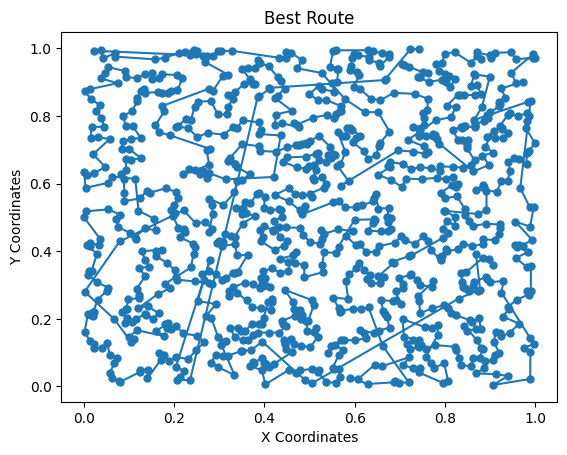

Best route found: [283, 683, 49, 609, 501, 382, 190, 640, 393, 935, 836, 626, 708, 442, 495, 360, 666, 956, 766, 356, 827, 423, 600, 948, 138, 146, 724, 232, 459, 749, 570, 532, 231, 996, 799, 917, 302, 337, 234, 650, 389, 260, 803, 854, 341, 258, 491, 789, 21, 40, 556, 716, 642, 762, 873, 487, 738, 648, 785, 654, 851, 307, 103, 43, 911, 674, 433, 396, 631, 915, 111, 696, 633, 739, 255, 414, 627, 853, 461, 823, 454, 191, 929, 126, 687, 220, 574, 580, 585, 782, 682, 926, 792, 531, 582, 201, 253, 101, 547, 361, 808, 100, 182, 296, 333, 120, 771, 402, 586, 943, 29, 783, 444, 794, 53, 729, 691, 376, 770, 824, 93, 939, 866, 233, 637, 670, 937, 34, 343, 613, 743, 530, 323, 646, 876, 377, 634, 896, 761, 71, 685, 550, 24, 374, 928, 261, 329, 963, 437, 139, 244, 519, 295, 44, 899, 987, 242, 128, 551, 368, 265, 460, 326, 369, 413, 167, 680, 470, 777, 852, 412, 653, 727, 535, 335, 845, 946, 560, 188, 596, 658, 373, 80, 951, 110, 599, 410, 77, 819, 311, 131, 875, 592, 478, 132, 947, 855, 829, 394,

In [9]:
# We here set the intialization particles method to be nearest_neighbor to see the output the algorithm will give and then see how it will do with other intilization method ( random )
# and particles to be 20 

num_particles = 20                 # Setting the number of populations 
max_iterations = 100               # Setting the number of iterations
inertia_weight = 0.7               # Setting the inertia weight
cognitive_weight = 1.5             # Setting the Cognitive weight
social_weight = 1.5                # Setting the social weight
crowding_factor = 10               # parameter to control the strength of crowding


# Using PSO algo with using nearest neighbor to help intializing smarter particles routes to start with 
best_route, best_distance = pso_tsp(num_particles, max_iterations, inertia_weight, cognitive_weight, social_weight,crowding_factor,"nearest_neighbor")

with open("./image/best_routePSo.txt", "w") as f:

    f.write("Distance: {}".format(best_distance))
    
# Plot the best route
xs = [cities[i][0] for i in best_route]
ys = [cities[i][1] for i in best_route]

plt.plot(xs, ys, 'o-', markersize=5)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Best Route')
plt.savefig('./image/best_routePSo.png')
plt.show()

print("Best route found:", best_route)
print("Distance of the best route:", best_distance)

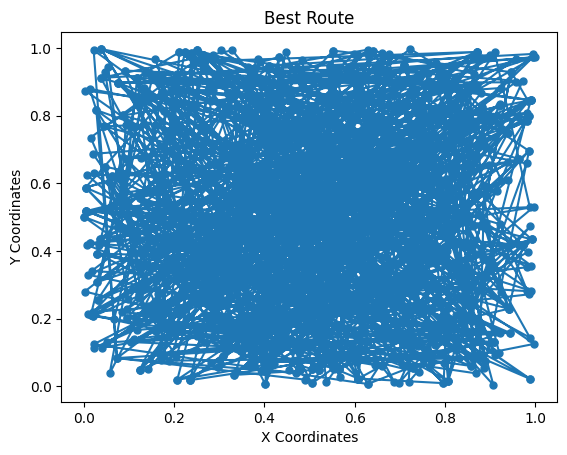

Best route found: [496, 543, 397, 803, 193, 5, 768, 128, 415, 204, 758, 499, 164, 835, 180, 385, 982, 851, 488, 277, 671, 190, 948, 918, 676, 603, 210, 744, 443, 961, 458, 388, 629, 593, 501, 507, 543, 296, 720, 600, 728, 510, 216, 863, 394, 310, 296, 44, 200, 622, 594, 344, 392, 727, 309, 663, 575, 867, 260, 36, 676, 934, 617, 36, 351, 404, 477, 641, 939, 30, 321, 765, 591, 932, 99, 80, 355, 196, 99, 649, 433, 55, 309, 670, 904, 602, 78, 592, 709, 829, 714, 462, 600, 899, 412, 496, 479, 259, 599, 925, 819, 688, 376, 828, 692, 229, 493, 88, 483, 807, 870, 115, 596, 360, 271, 966, 737, 261, 461, 910, 663, 89, 499, 70, 308, 612, 554, 509, 474, 516, 691, 750, 415, 7, 974, 542, 726, 414, 74, 413, 906, 54, 634, 753, 411, 358, 43, 522, 295, 633, 634, 406, 999, 669, 468, 416, 945, 143, 313, 482, 863, 743, 578, 69, 881, 380, 482, 389, 55, 239, 241, 290, 312, 362, 153, 502, 25, 954, 271, 699, 805, 809, 720, 757, 39, 786, 945, 539, 536, 495, 416, 407, 359, 601, 366, 214, 308, 432, 83, 709, 493, 

In [10]:
# This time we set the intialization particles method to be random to see the effect it does on the algorithm
# and particles to be 20 


num_particles = 20                 # Setting the number of populations 
max_iterations = 100               # Setting the number of iterations
inertia_weight = 0.7               # Setting the inertia weight
cognitive_weight = 1.5             # Setting the Cognitive weight
social_weight = 1.5                # Setting the social weight
crowding_factor = 10               # parameter to control the strength of crowding


# Using PSO algo with using random intializing to see how much of differnt it will make to our algorithm output
best_route, best_distance = pso_tsp(num_particles, max_iterations, inertia_weight, cognitive_weight, social_weight,crowding_factor,"random")

# Plot the best route
xs = [cities[i][0] for i in best_route]
ys = [cities[i][1] for i in best_route]

plt.plot(xs, ys, 'o-', markersize=5)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Best Route')
plt.show()

print("Best route found:", best_route)
print("Distance of the best route:", best_distance)

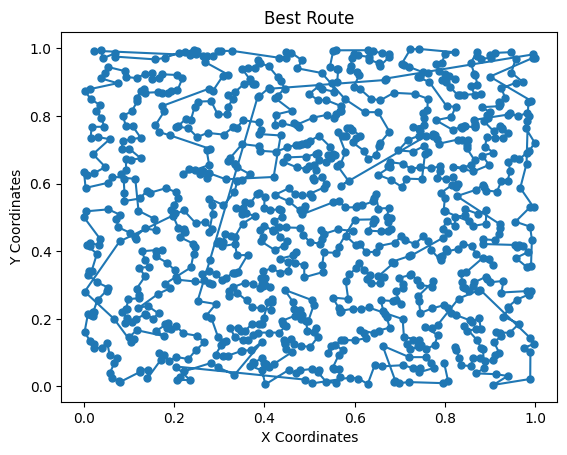

Best route found: [94, 621, 952, 435, 590, 765, 644, 5, 162, 971, 342, 499, 421, 518, 563, 400, 604, 913, 536, 293, 163, 523, 577, 772, 624, 248, 619, 31, 558, 544, 931, 240, 271, 445, 279, 408, 995, 312, 218, 561, 446, 582, 201, 253, 101, 547, 361, 808, 100, 182, 296, 333, 120, 771, 402, 586, 943, 29, 783, 444, 794, 53, 729, 691, 376, 770, 824, 93, 939, 866, 233, 637, 670, 937, 34, 343, 613, 743, 530, 323, 646, 876, 377, 634, 896, 761, 71, 685, 550, 24, 374, 928, 261, 329, 963, 437, 139, 244, 519, 295, 44, 899, 987, 242, 128, 551, 368, 265, 460, 326, 369, 413, 167, 680, 470, 777, 852, 412, 653, 727, 535, 335, 845, 946, 560, 188, 596, 658, 373, 80, 951, 110, 599, 410, 77, 819, 311, 131, 875, 592, 478, 132, 947, 855, 829, 394, 135, 462, 365, 754, 59, 804, 367, 614, 920, 310, 152, 953, 932, 773, 693, 630, 865, 694, 247, 779, 705, 858, 172, 63, 439, 812, 591, 114, 863, 944, 52, 960, 622, 27, 900, 168, 57, 885, 330, 902, 289, 818, 384, 189, 156, 505, 252, 266, 67, 997, 517, 608, 436, 833, 

In [11]:
# This time we set the number of particles to be 100 to see the effect of large population
# and particles to be 20 


num_particles = 100                 # Setting the number of populations 
max_iterations = 100               # Setting the number of iterations
inertia_weight = 0.7               # Setting the inertia weight
cognitive_weight = 1.5             # Setting the Cognitive weight
social_weight = 1.5                # Setting the social weight
crowding_factor = 10               # parameter to control the strength of crowding


# Using PSO algo with using random intializing to see how much of differnt it will make to our algorithm output
best_route, best_distance = pso_tsp(num_particles, max_iterations, inertia_weight, cognitive_weight, social_weight,crowding_factor,"nearest_neighbor")

# Plot the best route
xs = [cities[i][0] for i in best_route]
ys = [cities[i][1] for i in best_route]

plt.plot(xs, ys, 'o-', markersize=5)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Best Route')
plt.show()

print("Best route found:", best_route)
print("Distance of the best route:", best_distance)